# Introduction


**Table of Contents**
* [Preliminary imports](#imports)
* [Rectifications](#rectification)
* [Matching](#matching)
* [Compositon](#compositon)
* [Saving](#saving)

# Imports <a class="anchor" id="imports"></a>

In [1]:
from innotation_functions import *

In [2]:
from cadastre_matching import *

In [3]:
import os
from matplotlib.pyplot import cm

In [4]:
%load_ext autoreload
%autoreload 2

# Rectifications <a class="anchor" id="rectification"></a>

## Initialization

In [5]:
PATH_TO_REORIENT = "../1811_La Rochelle/"
img_ext = ".jpg"

new_filename_prefix = "LaRochelle_1811_"

reorient_input = True
rename_input = True
rescale_input = False

In [ ]:
flnms = os.listdir(PATH_TO_REORIENT)
flnms = [fln for fln in flnms if fln.endswith(img_ext)]

# REDUCE FOR TESTING
flnms = [fln for fln in flnms[:5] if fln.endswith(img_ext)]


images = [cv2.imread(PATH_TO_REORIENT+im) for im in flnms]

## Innotation

In [34]:
innotater_rect, targets_rect = innotate_rectification(images
                                    , flnms
                                    , reorient = reorient_input
                                    , rename = rename_input
                                    , rescale = rescale_input
                                   )

In [35]:
display(innotater_rect)

Innotater(children=(VBox(children=(VBox(children=(Text(value='frad017_22_3p_5074_6.jpg', disabled=True), Image…

## Transformation

In [36]:
selected_images, selected_targets = perform_selection(targets_rect
                                                      , images
                                                      , flnms
                                                      , rename = rename_input
                                                     )

In [37]:
%%time
if reorient_input:
    rotation_angles = orientation_angles(targets_orient=selected_targets[2])
    selected_images = rotate_images(images=selected_images, orientation_angles=rotation_angles)

/Users/nmm/Desktop/DH-MA3/fdh/ToolDevelopment/innotation_functions.py:257: RuntimeWarning: divide by zero encountered in long_scalars
  angles = [np.arctan(nv[1]/nv[0])*180/np.pi for nv in north_vectors]


CPU times: user 2.3 s, sys: 376 ms, total: 2.68 s
Wall time: 510 ms


## Check task completed ?

In [38]:
innotater_checking, targets_checking = innotate_rectification(images=selected_images
                                                              , flnms=selected_targets[1]
                                                              , reorient = False
                                                              , rename = False
                                                              , rescale = False
                                                              , exclude_name = "Not correctly rectified"
                                                             )

In [39]:
display(innotater_checking)

Innotater(children=(VBox(children=(VBox(children=(Text(value='D', disabled=True), ImagePad(value=b'\x89PNG\r\n…

In [40]:
to_be_recomputed = targets_checking[0]==1

In [41]:
if to_be_recomputed.any():
    innotater_recomputed, targets_recomputed = innotate_rectification(images=selected_images
                                                                      , flnms=selected_targets[1]
                                                                      , reorient = reorient_input
                                                                      , rename = rename_input
                                                                      , rescale = rescale_input
                                                                      , exclude_name = "Exclude"
                                                                      , ind_to_compute = to_be_recomputed
                                                                     )
    display(innotater_recomputed)

In [42]:
if to_be_recomputed.any():
    # np.where for other targets !!!!!
    selected_images_test = [im if (np.sum(targ_reNorth)==0) 
                        else rotate_images(images=[im]
                                           , orientation_angles=orientation_angles([targ_reNorth])
                                          )[0]
                        for im, targ_reNorth in zip(selected_images, targets_recomputed[2])
                       ]

## Save rectified images

In [43]:
SAVE_RECTIFIED = True
SAVE_RECTIFIED_EDGES = False

rectified_path = PATH_TO_REORIENT+"rectified"

In [44]:
if SAVE_RECTIFIED:
    save_rectified_images(path=rectified_path+"/"
                          , rectified_images=selected_images
                          , rectified_flnms=selected_targets[1]
                          , new_filename_prefix=new_filename_prefix
                          , img_ext=img_ext
                         )

In [45]:
if SAVE_RECTIFIED_EDGES:
    edges = [cv2.Canny(im,220,256) for im in selected_images]
    save_rectified_images(path=rectified_path+"_edges/"
                          , rectified_images=edges
                          , rectified_flnms=selected_targets[1]
                          , new_filename_prefix=new_filename_prefix
                          , img_ext=img_ext
                         )

# Matching <a class="anchor" id="matching"></a>

## Initialization

In [6]:
FOLDER_ANNOT = PATH_TO_REORIENT+"renamed/"#"rectified/"#'../1811_La Rochelle/rectified/'
FOLDER_COMPOSE = PATH_TO_REORIENT+"renamed_edges/"#"rectified/"[:-1]+"_edges/"#'../1811_La Rochelle/rectified_edges/'
FOLDER_MATCH = PATH_TO_REORIENT+"renamed/"#"rectified/"#'../1811_La Rochelle/rectified/'

In [7]:
img_prefix = new_filename_prefix#'LaRochelle_1811_'

In [8]:
img_ext = img_ext#".jpeg"#".jpg"

## Matching process

First the network is inisialized empty. It will be filled with the matches found afterwards.

In [11]:
initialisation = True

In [12]:
# not to reinitialise by mistake and loose the work done
if initialisation:
    initialisation = False
    G = nx.DiGraph()

In order to make the network grow and to compute matches the following cells should be run iteratively, following:

1. Run the next cell
    1. Type the label of the anchor cadastre <kbd>Enter</kbd>
    1. Type the label of the target cadastre <kbd>Enter</kbd><br />
    Both of the images will be displayed with the anchor cadastre on the left and the target one on the right.
    1. Select on the left cadastre the template.
    1. Select on the right cadastre the area on which to match the cadastre.
1. Run the second next cell<br />
    1. The composition based on the best match found will be displayed.
    1. The machine will ask you if the match is satisfying. 
        1. Type "`y`" if it is satisfying to store the match.<br />
           You can go back to step `1` and iterate.
        2. Type anything but "`y`" if the match is not satisfying. It will be discarded.<br />
           You can either select new template or matching area (go back to `1.C` or `1.D`) or dropping this pair for now and going back to step `1`.
1. Whenever you want to see the advances of your progresses you can go the third next cell to visualise the network or to the [next section](#composition) to see the composed image of the area covered.
1. Finally the fourth next cell is here if you saved a match that should have been discarded. Run it to go back to the previous state of the network.

In [40]:
anchor_label, target_label = initialize_match()

inw, targets = innotater_init(anchor_label
                              , target_label
                              , path=FOLDER_ANNOT+img_prefix
                              , im_ext=img_ext
                             )
display(inw)

Anchor cadaster label:  B
Target cadaster label:  A2


Innotater(children=(VBox(children=(VBox(children=(HBox(children=(ImagePad(value=b'\xff\xd8\xff\xe0\x00\x10JFIF…

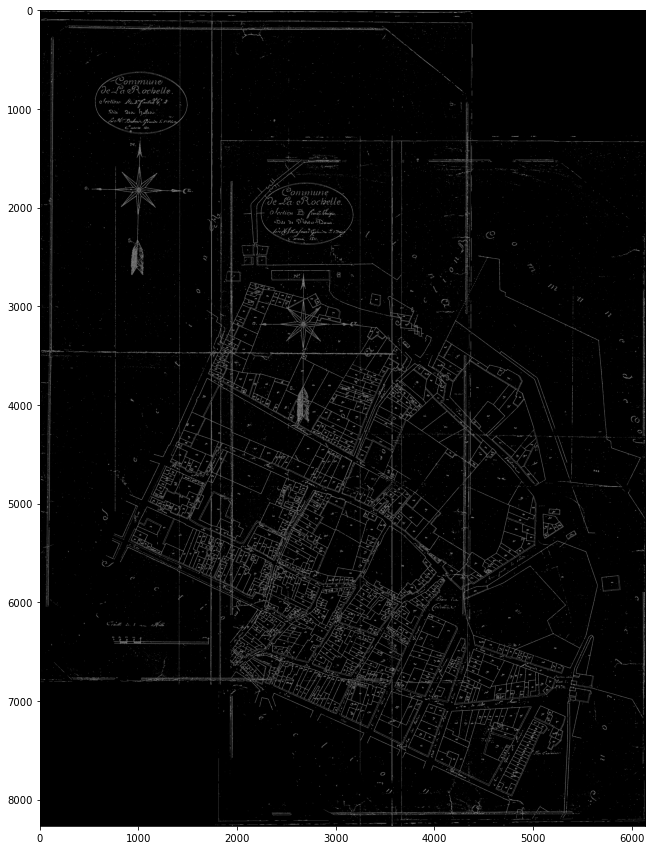

Is it OK?


 y


MATCH ADDED TO THE NETWORK
Current nodes:['A1', 'A2', 'D', 'E', 'C', 'F1', 'F2', 'B']


In [42]:
prev_G = G

G = test_match_network(targets
                       , path_match=FOLDER_COMPOSE+img_prefix
                       , anchor_label=anchor_label
                       , target_label=target_label
                       , img_ext=img_ext
                       , path_compose = FOLDER_COMPOSE+img_prefix
                       , G = G
                       , orientation_match = True
                       , angles = np.linspace(-40,41, 60)
                      )

To have an glance on the state of the network built so far, you can run the following cell:

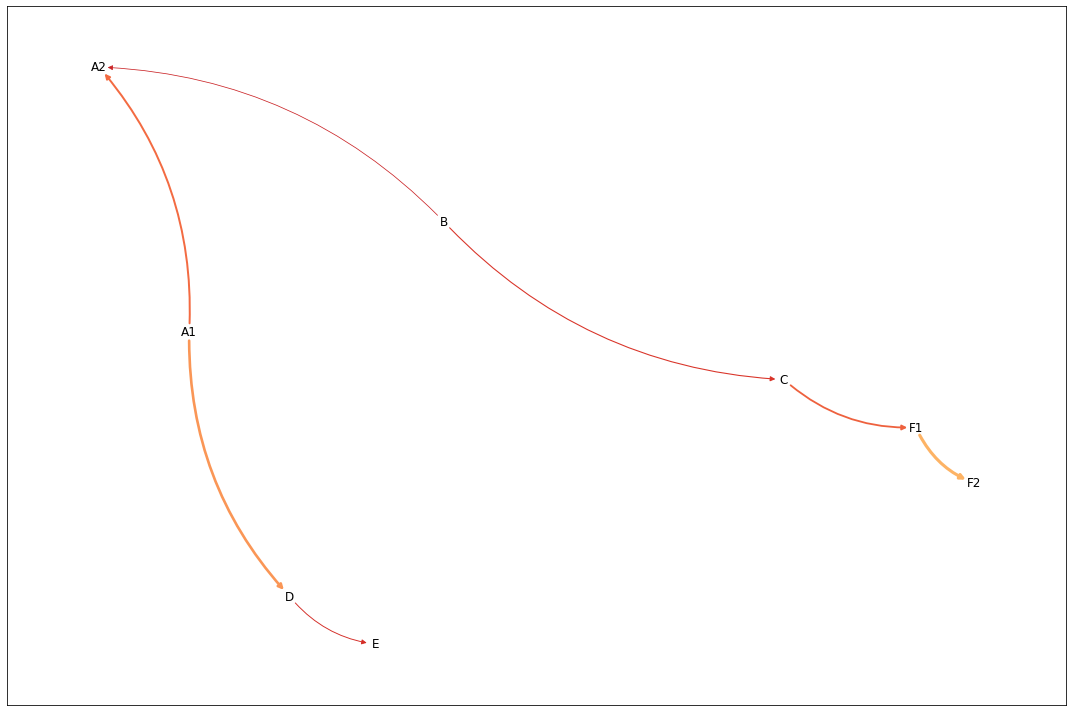

In [43]:
visualize_network(G)

In [49]:
print("Do you want to discard the last saved match ? (y/n) ")
reverse_step = input()
if reverse_step == "y":
    G = prev_G

Do you want to discard the last saved match ? (y/n) 


 n


# Composition <a class="anchor" id="composition"></a>

`network2Image` function allows to build the image of the area covered by the graph and linked to the initial cadastre given to the function (without consideration of directionnality).

In [47]:
BigIm = network2Image(G
                      , init_label='A1'
                      , img_ext=img_ext
                      , path_compose=FOLDER_COMPOSE+img_prefix
                     )

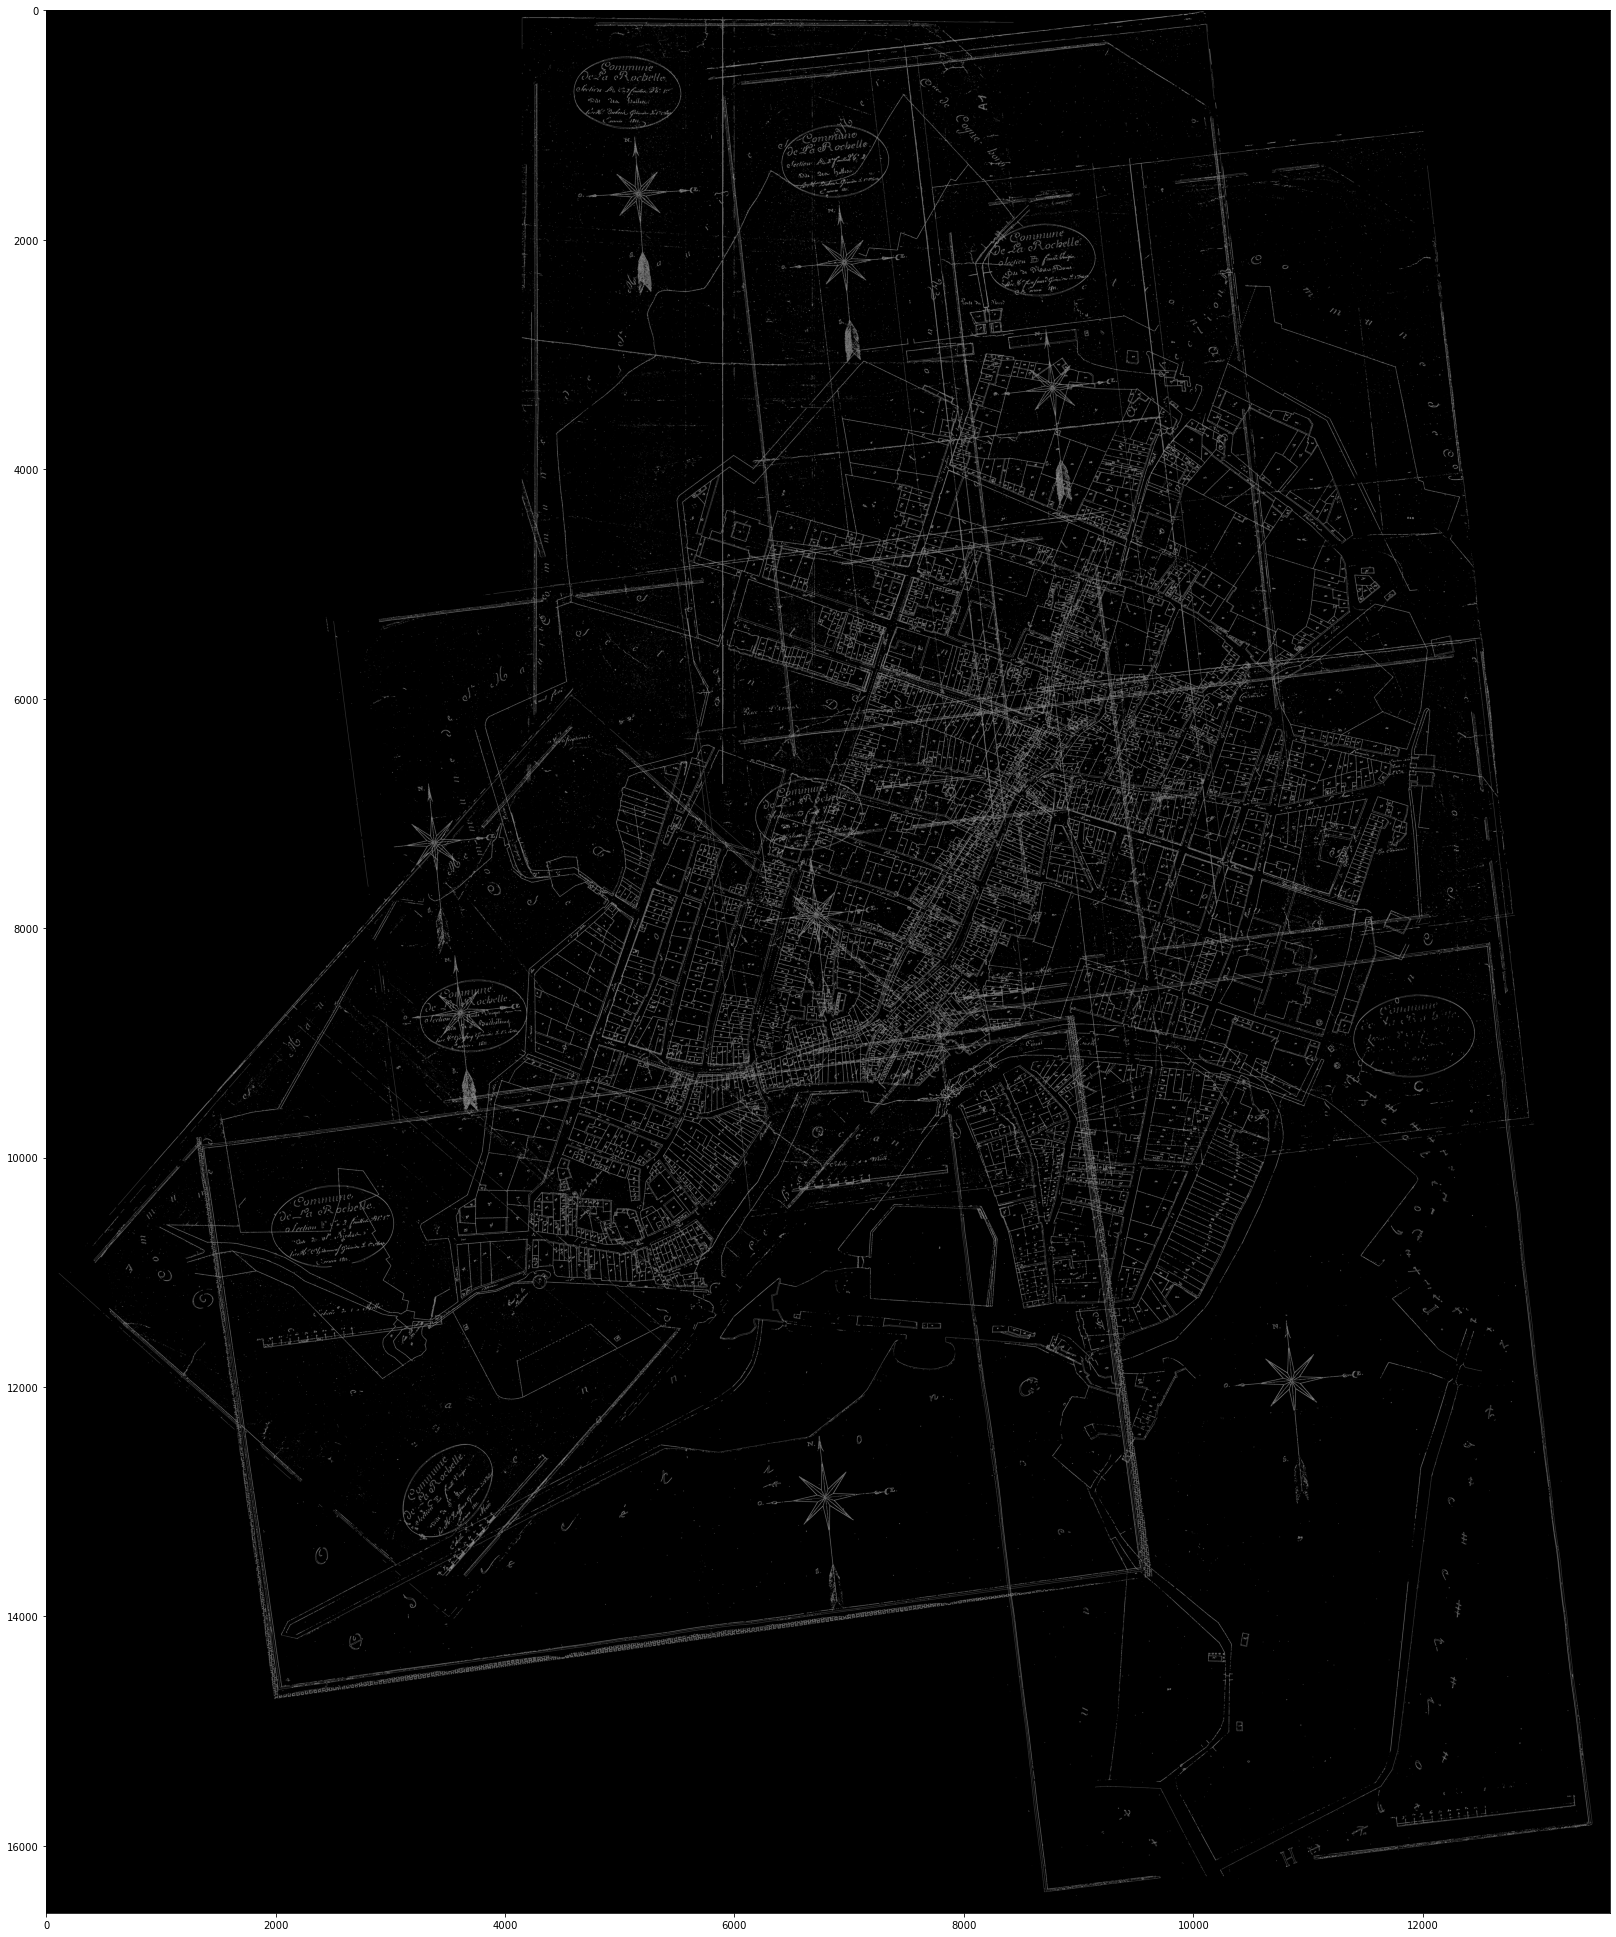

In [48]:
plt.figure(figsize=(35,35))
plt_plot_cv2(BigIm)

# Saving <a class="anchor" id="saving"></a>

By running the following cell, the will be stored as a `.json` file with the following structure:

```json
{
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [{
        "h": int — height of the corresponding image,
        "w": int — width of the corresponding image,
        "label": str — name
    }, {
        "h": int — height of the corresponding image,
        "w": int — width of the corresponding image,
        "label": str — name
    }],
    "match": [{
        "score": float — score of the template matching process,
        "anchor_tl": tuple: two int — coordinate of the template top left corner on the anchor,
        "anchor_br": tuple: two int — coordinate of the template bottom right corner on the anchor,
        "target_tl": tuple: two int — coordinate corresponding to anchor_tl on target,
        "target_br": tuple: two int — coordinate corresponding to anchor_br on target,
        "anchor": str — name of the anchor cadastre\node,
        "target": str — name of the target cadastre\node
    }]
}
```

The second next cell can be used to load previously saved graphs.

In [ ]:
save_json_graph(test_net, path='saved_graph.json')

In [ ]:
G = load_json_graph(path='saved_graph.json')